# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

You should produce a Jupyter notebook and a `.txt` file (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

Place your notebook and `.txt` files **only** in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 3 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
%matplotlib inline

## Description of the dataset
In this assignment our goal is to recognize objects from 19 dierent visual classes (e.g. person, dog, cat, car, ...) in realistic scenes. The dataset consists of several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

Here we will focus on a single classiffication task: you will be required to classify images as to whether or not they contain a person. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. That is, each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 diffeerent visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image). Our dataset with all images is thus a $N \times 500$ dimensional matrix where `N` is the number of images. The resulting representation is much more compact and can be used directly to perform classiffication.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) correspond to the normalized count vector. The last 19 attributes (`is_class`) indicate the presence of at least one object of a particular class in the image. In most of the experiments (unless explicitly noted otherwise) you will be asked to train classiffiers for classifying person vs. non-person images and only the `is_person` attribute and the 500 dimensional feature vector will be used. Do not use the additional class indicator attributes as features unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

*Important: Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 ==========
Load the datasets `train_images_partA.csv` and `valid_images_partA.csv` into two pandas DataFrame called `train_A` and `valid_A`. Display the number of data points and attributes in each of the two datasets.

In [21]:
train_A = pd.read_csv('datasets/train_images_partA.csv')
valid_A = pd.read_csv('datasets/valid_images_partA.csv')

print('train_A has {} points and {} attributes'.format(train_A.shape[0], train_A.shape[1]))
print('valid_A has {} points and {} attributes'.format(valid_A.shape[0], valid_A.shape[1]))

train_A has 2093 points and 520 attributes
valid_A has 1113 points and 520 attributes


### ========== Question 1.2 ==========
Display and inspect the first 10 instances in the training dataset.

In [22]:
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Not sure what "inspect" means but here are summary stats for the first 10:
train_A.head(10).describe()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.0,10.0,10.0,10.000000
mean,0.001323,0.001378,0.003231,0.000981,0.001586,0.002861,0.000965,0.003613,0.001945,0.002949,...,0.0,0.100000,0.100000,0.100000,0.0,0.400000,0.0,0.0,0.0,0.100000
std,0.000967,0.001930,0.002671,0.001001,0.001267,0.002186,0.000809,0.002370,0.001667,0.002110,...,0.0,0.316228,0.316228,0.316228,0.0,0.516398,0.0,0.0,0.0,0.316228
min,0.000000,0.000000,0.000000,0.000279,0.000372,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
25%,0.000600,0.000340,0.000619,0.000348,0.000719,0.001507,0.000340,0.002260,0.000093,0.001762,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
50%,0.001189,0.000474,0.003603,0.000605,0.001359,0.002135,0.000882,0.003219,0.002505,0.002645,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
75%,0.002065,0.002014,0.004682,0.001036,0.001646,0.004743,0.001386,0.004076,0.003397,0.004755,...,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000
max,0.002976,0.006324,0.007422,0.003516,0.003906,0.006114,0.002378,0.008185,0.003646,0.006138,...,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000


### ========== Question 1.3 ==========
In this part we want to select the appopriate attributes (i.e. input features) for training our classifiers. These should be the attributes `dim1, dim2, ..., dim500`. Create a list which has as elements the **names** of the attributes of interest. 

In [24]:
attrs = ['dim{}'.format(n) for n in xrange(1, 501)]

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` and store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets (also make sure you do not include this attribute in your training features). Display the dimensionalities (i.e shapes) of the 4 arrays and make sure your input data are 500-dimensional.

In [25]:
X_tr = train_A[attrs]
y_tr = train_A['is_person']
X_val = valid_A[attrs]
y_val = valid_A['is_person']
print('Shape of X_tr: {}'.format(X_tr.shape))
print('Shape of y_tr: {}'.format(y_tr.shape))
print()
print('Shape of X_val: {}'.format(X_val.shape))
print('Shape of y_val: {}'.format(y_val.shape))

Shape of X_tr: (2093, 500)
Shape of y_tr: (2093,)

Shape of X_val: (1113, 500)
Shape of y_val: (1113,)


### ========== Question 1.5 ==========
Show two [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) of the targets in a single plot, one for the training and one for the validation set. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

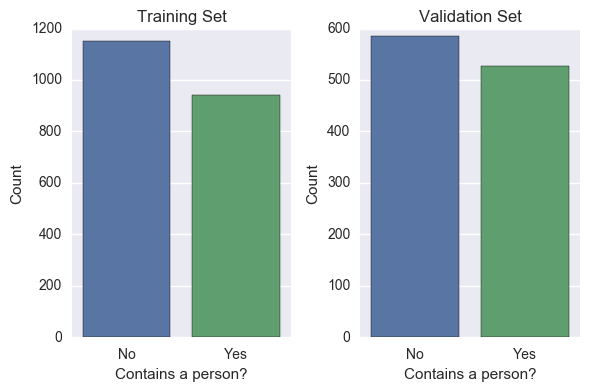

In [43]:
fig = plt.figure()

fig.add_subplot(121)
sns.countplot(x = y_tr)
plt.xticks([0, 1], ['No', 'Yes'])
plt.xlabel('Contains a person?')
plt.ylabel('Count')
plt.title('Training Set')

fig.add_subplot(122)
sns.countplot(x = y_val)
plt.xticks([0, 1], ['No', 'Yes'])
plt.xlabel('Contains a person?')
plt.ylabel('Count')
plt.title('Validation Set')

plt.tight_layout()
plt.show()

### ========== Question 1.6 ==========
What would be a good choice for a baseline classifier to compare your results in the next steps against? What classification accuracy score does the baseline classifier achieve in the validation set?

Most images do not contain a person, so a good baseline to use is that in which all images are classified as such.

In [29]:
print('Accuracy when all points are assigned to class 0: {}'.format(y_val.value_counts()[0] / len(y_val)))

Accuracy when all points are assigned to class 0: 0.5265049415992812


### ========== Question 1.7 ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score in the training and validation sets and compare to that of the baseline classifier. Comment in 1-2 sentences the results. You may include any additional plot(s) if you wish to justify your explanation.

In [30]:
lrc = LogisticRegression(solver = 'lbfgs')
lrc.fit(X_tr, y_tr)

print('Accuracy on training set: {}'.format(lrc.score(X_tr, y_tr)))
print('Accuracy on validation set: {}'.format(lrc.score(X_val, y_val)))

Accuracy on training set: 0.5508838987099857
Accuracy on validation set: 0.5265049415992812


The accuracy of the logistic regression classifier is very low, matching the baseline accuracy for the validation set. This suggests that it is assigning all points to class 0, and the following plots demonstrate that this is indeed the case.

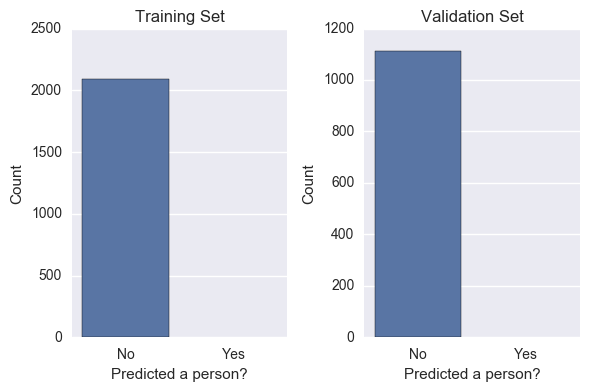

In [45]:
fig = plt.figure()

fig.add_subplot(121)
sns.countplot(x = lrc.predict(X_tr))
plt.xticks([0, 1, 1.5], ['No', 'Yes'])
plt.xlabel('Predicted a person?')
plt.ylabel('Count')
plt.title('Training Set')

fig.add_subplot(122)
sns.countplot(x = lrc.predict(X_val))
plt.xticks([0, 1, 1.5], ['No', 'Yes'])
plt.xlabel('Predicted a person?')
plt.ylabel('Count')
plt.title('Validation Set')

plt.tight_layout()
plt.show()

### ========== Question 1.8 ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [46]:
# Not sure what is meant by "across the columns," since attributes correspond to columns and their mean/sd would be
# calculated per-column. This is essentially the same as X_tr.mean(axis = 0)[:5] and similarly for sd. One could also
# use X_tr[X_tr.columns[:5]].mean(axis = 1) and calculate mean/sd for each datapoint using only the first five columns,
# but that seems pointless.

for col in X_tr.columns[:5]:
    print('(mean, sd) of attribute {}: {}'.format(col, (X_tr[col].mean(), X_tr[col].std())))

(mean, sd) of attribute dim1: (0.0017505776397515665, 0.0011930946342307437)
(mean, sd) of attribute dim2: (0.0007559225991399952, 0.0014063713684971735)
(mean, sd) of attribute dim3: (0.004316947921643566, 0.003693435646445931)
(mean, sd) of attribute dim4: (0.0018527792642140607, 0.0013404915150502222)
(mean, sd) of attribute dim5: (0.002272475394171055, 0.001598113642137162)


### ========== Question 1.9 ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers an [implementation](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Create a standardiser and fit it by using training features only. Then transform both your input and validation input features. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. 

**IMPORTANT: You should use the transformed data for the rest of part A**.

In [47]:
ss = StandardScaler()
ss.fit(X_tr)
X_tr_s = pd.DataFrame(data = ss.transform(X_tr), columns = X_tr.columns)
X_val_s = pd.DataFrame(data = ss.transform(X_val), columns = X_val.columns)

for col in X_tr.columns[:5]:
    print('(mean, sd) of training attribute {}: {}'.format(col, (X_tr_s[col].mean(), X_tr_s[col].std())))
    print('(mean, sd) of validation attribute {}: {}'.format(col, (X_val_s[col].mean(), X_val_s[col].std())))

(mean, sd) of training attribute dim1: (2.2066544588822986e-17, 1.0002389771810862)
(mean, sd) of validation attribute dim1: (-0.005506123243252273, 1.0135642947930597)
(mean, sd) of training attribute dim2: (2.2082457962324543e-16, 1.0002389771810913)
(mean, sd) of validation attribute dim2: (-0.03829330201046744, 0.9702554644849994)
(mean, sd) of training attribute dim3: (2.6829947723621797e-16, 1.000238977181093)
(mean, sd) of validation attribute dim3: (0.1091509765934861, 1.0497001676688393)
(mean, sd) of training attribute dim4: (1.6083116152238293e-16, 1.0002389771810871)
(mean, sd) of validation attribute dim4: (0.09369313905715072, 1.0573198813626055)
(mean, sd) of training attribute dim5: (-2.6933384651381903e-17, 1.0002389771810896)
(mean, sd) of validation attribute dim5: (0.030578437247359147, 0.9751515348282603)


The results of the feature standardization process are as expected. The mean and standard deviation of the training data are all within floating-point error of 0 and 1, respectively, as desired. There is no expectation that this would be true of the validation data, as it would have different means and variances for each attribute, and thus the same transformation would not achieve these conditions.

### ========== Question 1.10 ==========
By using the transformed input data, retrain a `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy in both the training and validation sets. How does your model compare to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [48]:
lrc = LogisticRegression(solver = 'lbfgs')
lrc.fit(X_tr_s, y_tr)

print('Accuracy on training set: {}'.format(lrc.score(X_tr_s, y_tr)))
print('Accuracy on validation set: {}'.format(lrc.score(X_val_s, y_val)))

Accuracy on training set: 0.8107978977544195
Accuracy on validation set: 0.6433063791554358


The accuracy of the logistic regression classifier using standardized data is higher than the results from before, beating the baseline. Mathematically, we can see that it must be classifying some of both classes correctly in order to achieve this.

### ========== Question 1.11 ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes for the weight vector. Thus, it helps us prevent overfitting and, for logistic regression, it additionally controls the level of confidence in making predictions.

We would like to optimise this parameter **by using the transformed training dataset only** and not the validation set. Create a 3-fold cross-validation object for the training dataset. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples in each iteration fold.

In [49]:
kf = KFold(len(X_tr_s), n_folds = 3, shuffle = True, random_state = 0)
for i, (training, testing) in enumerate(kf):
    print('Number of test samples for fold {}: {}'.format(i, len(testing)))

Number of test samples for fold 0: 698
Number of test samples for fold 1: 698
Number of test samples for fold 2: 697


### ========== Question 1.12 ========== 
Now we want to test out different settings for the regularisation parameter `C` by using the cross-validation iterator from the previous question. For each iteration, we want to train multiple classifiers by using a range of values for `C` and then compute the performance within each CV fold. You should use a log-range for `C` from `1e-5` to `1e5` by using 20 equally-spaced values *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters.

*(hint: your may want to use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [50]:
Cs = np.logspace(-5, 5, num = 20)
scores = []
for i, C in enumerate(Cs):
    scores.append([])
    lrc = LogisticRegression(C = C, solver = 'lbfgs')
    for training, testing in kf:
        lrc.fit(X_tr_s.iloc[training], y_tr[training])
        scores[i].append(lrc.score(X_tr_s.iloc[testing], y_tr[testing]))

### ========== Question 1.13 ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

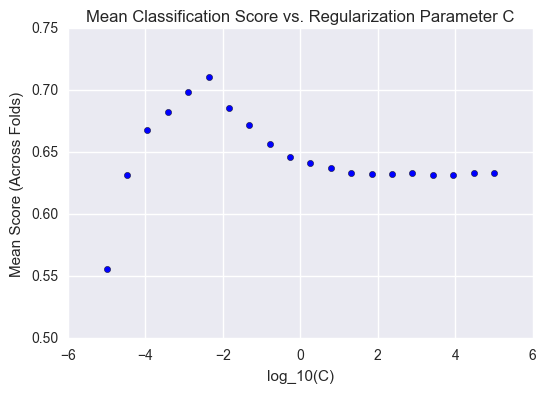

In [51]:
plt.figure()
plt.scatter(np.log10(Cs), [np.mean(folds) for folds in scores])
plt.xlabel('log_10(C)')
plt.ylabel('Mean Score (Across Folds)')
plt.title('Mean Classification Score vs. Regularization Parameter C')
plt.show()

### ========== Question 1.14 ==========
Find and display the optimal value for the regularisation parameter `C` of the logistic classifier by using your results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [52]:
C = Cs[max(enumerate(np.mean(folds) for folds in scores), key = lambda p: p[1])[0]]
print('Optimal value of C: {}'.format(C))

lrc = LogisticRegression(C = C, solver = 'lbfgs')
lrc.fit(X_tr_s, y_tr)
print('Score on validation set: {}'.format(lrc.score(X_val_s, y_val)))

Optimal value of C: 0.004281332398719391
Score on validation set: 0.6963162623539982


### ========== Question 1.15 ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Can you verify that your results are consistent with those from Question 1.14?

In [53]:
lrcv = LogisticRegressionCV(Cs = Cs, cv = kf, solver = 'lbfgs')
lrcv.fit(X_tr_s, y_tr)
print('Optimal value of C: {}'.format(lrcv.C_[0]))                      # exactly as above
print('Score on validation set: {}'.format(lrcv.score(X_val_s, y_val))) # exactly as above

Optimal value of C: 0.004281332398719391
Score on validation set: 0.6963162623539982


### ========== Question 1.16 ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 31 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [54]:
rfc = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
rfc.fit(X_tr_s, y_tr)

print('Score on training set: {}'.format(rfc.score(X_tr_s, y_tr)))
print('Score on validation set: {}'.format(rfc.score(X_val_s, y_val)))

Score on training set: 1.0
Score on validation set: 0.6909254267744834


### ========== Question 1.17 ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

I do not find the discrepancy particularly surprising. Random Forest classifiers grow each tree to maximum depth by default, so there will be a leaf for every training datapoint in each tree, and thus it will always classify them correctly. The score on the validation set is modest, but significantly better than the baseline, so the classification is somewhat successful, but likely overfit to the training data.

### ========== Question 1.18 ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [55]:
print('50 most important features:')
print([X_tr_s.columns[p[0]] for p in sorted(enumerate(rfc.feature_importances_),
                                            key = lambda p: p[1], reverse = True)[:50]])

50 most important features:
['dim21', 'dim360', 'dim76', 'dim51', 'dim479', 'dim4', 'dim330', 'dim343', 'dim461', 'dim254', 'dim222', 'dim423', 'dim398', 'dim217', 'dim485', 'dim283', 'dim348', 'dim263', 'dim356', 'dim500', 'dim274', 'dim288', 'dim171', 'dim90', 'dim347', 'dim74', 'dim326', 'dim73', 'dim214', 'dim153', 'dim17', 'dim483', 'dim289', 'dim77', 'dim154', 'dim427', 'dim54', 'dim322', 'dim48', 'dim35', 'dim92', 'dim312', 'dim188', 'dim96', 'dim353', 'dim430', 'dim315', 'dim206', 'dim201', 'dim329']


### ========== Question 1.19 ==========
Next, we would like to test out the performance of support vector classification and experiment with different kernels. 
By using training data only and default parameter settings, train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [56]:
lsvc = SVC(kernel = 'linear')
lsvc.fit(X_tr_s, y_tr)
print('Linear SVC training set score: {}'.format(lsvc.score(X_tr_s, y_tr)))
print('Linear SVC validation set score: {}'.format(lsvc.score(X_val_s, y_val)))

rsvc = SVC(kernel = 'rbf')
rsvc.fit(X_tr_s, y_tr)
print('RBF SVC training set score: {}'.format(rsvc.score(X_tr_s, y_tr)))
print('RBF SVC validation set score: {}'.format(rsvc.score(X_val_s, y_val)))

psvc = SVC(kernel = 'poly')
psvc.fit(X_tr_s, y_tr)
print('Polynomial SVC training set score: {}'.format(psvc.score(X_tr_s, y_tr)))
print('Polynomial SVC validation set score: {}'.format(psvc.score(X_val_s, y_val)))

Linear SVC training set score: 0.8423315814620163
Linear SVC validation set score: 0.6388140161725068
RBF SVC training set score: 0.9106545628284759
RBF SVC validation set score: 0.7295597484276729
Polynomial SVC training set score: 0.9909221213569039
Polynomial SVC validation set score: 0.701707097933513


### ========== Question 1.20 ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the results by using 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [57]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

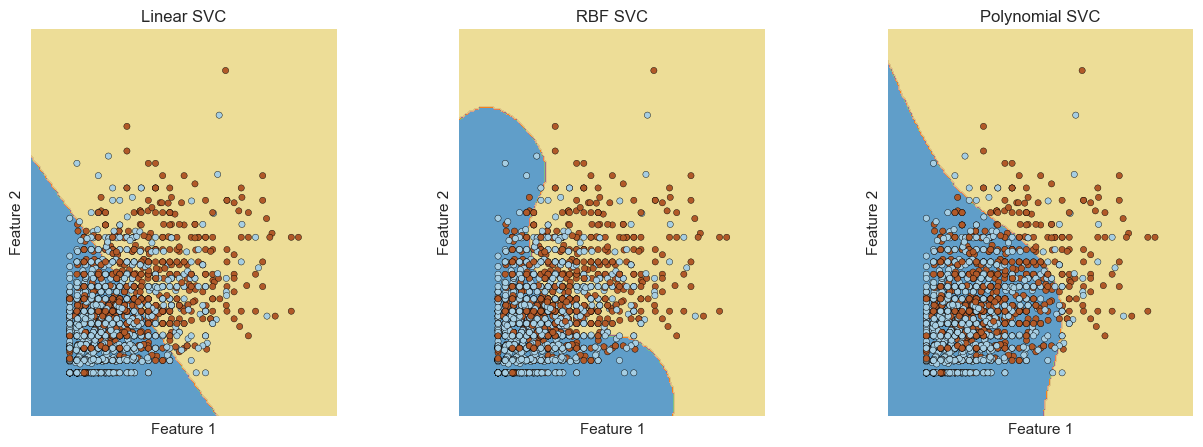

In [58]:
X_tr_s_2 = X_tr_s.as_matrix(columns = [X_tr_s.columns[20], X_tr_s.columns[75]])
lsvc.fit(X_tr_s_2, y_tr)
rsvc.fit(X_tr_s_2, y_tr)
psvc.fit(X_tr_s_2, y_tr)

show_svc_decision_boundaries([lsvc, rsvc, psvc], X_tr_s_2, title = ['Linear SVC', 'RBF SVC', 'Polynomial SVC'])

The above plots illustrate the general behavior of the three types of kernels. In a linear SVC, the decision boundary is based off a point's dot product with a linear combination of support vectors, yielding a simple hyperplane in both feature and input space. RBF SVC decision boundaries are based on nonlinear functions varying with distance from each support vector, and thus we see an input space curve with quasi-circular boundaries around the nearest support vectors. Polynomial boundaries use a polynomial function in the dot products, and thus we see some higher-order curve in input space without the radial features of an RBF SVC.

### ========== Question 1.21 ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

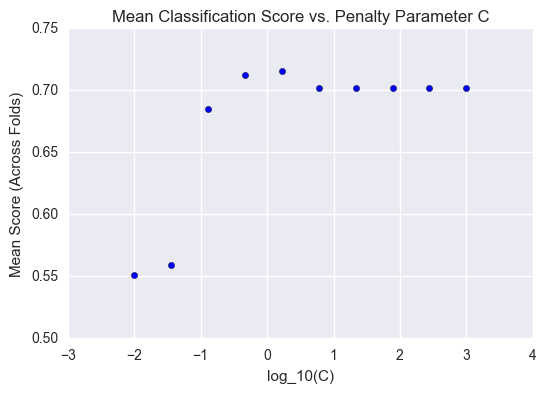

Optimal value of C: 1.6681005372000592
Optimal mean score: 0.7152306446374762
Score on training set: 0.9746774964166268
Score on validation set: 0.7277628032345014


In [59]:
Cs = np.logspace(-2, 3, num = 10)
scores = []
for i, C in enumerate(Cs):
    scores.append([])
    rsvc = SVC(C = C, kernel = 'rbf', gamma = 'auto')
    for training, testing in kf:
        rsvc.fit(X_tr_s.iloc[training], y_tr[training])
        scores[i].append(rsvc.score(X_tr_s.iloc[testing], y_tr[testing]))

plt.figure()
plt.scatter(np.log10(Cs), [np.mean(folds) for folds in scores])
plt.xlabel('log_10(C)')
plt.ylabel('Mean Score (Across Folds)')
plt.title('Mean Classification Score vs. Penalty Parameter C')
plt.show()

iC = max(enumerate(np.mean(folds) for folds in scores), key = lambda p: p[1])[0]
print('Optimal value of C: {}'.format(Cs[iC]))
print('Optimal mean score: {}'.format(np.mean(scores[iC])))

rsvc = SVC(C = Cs[iC], kernel = 'rbf', gamma = 'auto')
rsvc.fit(X_tr_s, y_tr)
print('Score on training set: {}'.format(rsvc.score(X_tr_s, y_tr)))
print('Score on validation set: {}'.format(rsvc.score(X_val_s, y_val)))

### ========== Question 1.22 ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

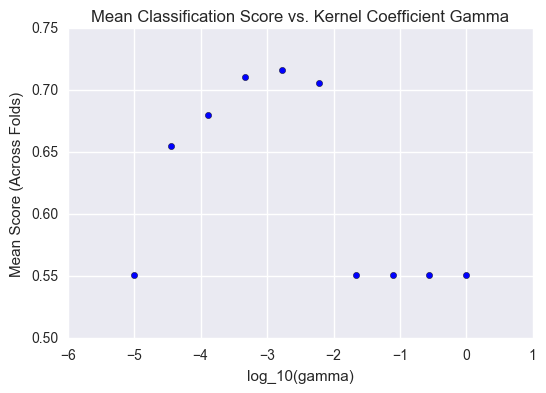

Optimal value of gamma: 0.0016681005372000592
Optimal mean score: 0.7161857544751076
Score on training set: 0.8910654562828476
Score on validation set: 0.7268643306379156


In [60]:
gammas = np.logspace(-5, 0, num = 10)
scores = []
for i, gamma in enumerate(gammas):
    scores.append([])
    rsvc = SVC(C = 1.0, kernel = 'rbf', gamma = gamma)
    for training, testing in kf:
        rsvc.fit(X_tr_s.iloc[training], y_tr[training])
        scores[i].append(rsvc.score(X_tr_s.iloc[testing], y_tr[testing]))

plt.figure()
plt.scatter(np.log10(gammas), [np.mean(folds) for folds in scores])
plt.xlabel('log_10(gamma)')
plt.ylabel('Mean Score (Across Folds)')
plt.title('Mean Classification Score vs. Kernel Coefficient Gamma')
plt.show()

igamma = max(enumerate(np.mean(folds) for folds in scores), key = lambda p: p[1])[0]
print('Optimal value of gamma: {}'.format(gammas[igamma]))
print('Optimal mean score: {}'.format(np.mean(scores[igamma])))

rsvc = SVC(C = 1.0, kernel = 'rbf', gamma = gammas[igamma])
rsvc.fit(X_tr_s, y_tr)
print('Score on training set: {}'.format(rsvc.score(X_tr_s, y_tr)))
print('Score on validation set: {}'.format(rsvc.score(X_val_s, y_val)))

### ========== Question 1.23 ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

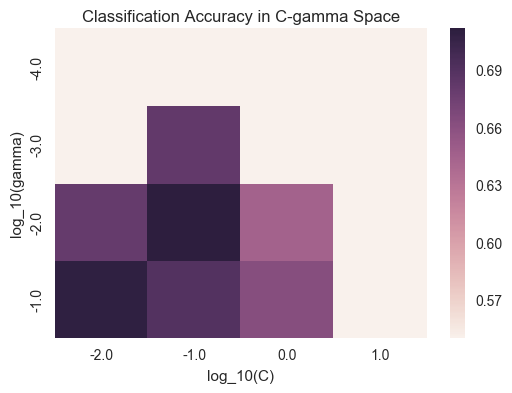

Optimal (C, gamma) pair: (1.0, 0.001)
Optimal mean score: 0.7123625744937713
Score on training set: 0.8346870520783565
Score on validation set: 0.7214734950584007


In [61]:
Cs = np.logspace(-2, 1, num = 4)
gammas = np.logspace(-4, -1, num = 4)

scores = []
for i, C in enumerate(Cs):
    scores.append([])
    for j, gamma in enumerate(gammas):
        scores[i].append([])
        rsvc = SVC(C = C, kernel = 'rbf', gamma = gamma)
        for training, testing in kf:
            rsvc.fit(X_tr_s.iloc[training], y_tr[training])
            scores[i][j].append(rsvc.score(X_tr_s.iloc[testing], y_tr[testing]))
            
        scores[i][j] = np.mean(scores[i][j])

plt.figure()
sns.heatmap(scores, xticklabels = np.log10(Cs), yticklabels = np.log10(gammas))
plt.xlabel('log_10(C)')
plt.ylabel('log_10(gamma)')
plt.title('Classification Accuracy in C-gamma Space')
plt.show()

max_ij = (0, 0)
max_score = 0
for i, Cscores in enumerate(scores):
    for j, score in enumerate(Cscores):
        if score > max_score:
            max_score = score
            max_ij = (i, j)

i, j = max_ij
C = Cs[i]
gamma = gammas[j]
print('Optimal (C, gamma) pair: {}'.format((C, gamma)))
print('Optimal mean score: {}'.format(scores[i][j]))

rsvc = SVC(C = C, kernel = 'rbf', gamma = gamma)
rsvc.fit(X_tr_s, y_tr)
print('Score on training set: {}'.format(rsvc.score(X_tr_s, y_tr)))
print('Score on validation set: {}'.format(rsvc.score(X_val_s, y_val)))

### ========== Question 1.24 ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

The classification accuracy on the validation set is almost the same as in the previous two questions. I speculate that this is due to the comparably limited search space, since changes in both C and gamma are greater here. This results in an optimal value of C that is slightly off from that of 1.22, but equal to the value of C used to find the optimal gamma in 1.23. Because the optimal gamma from 1.23 was in between the increments given here, there would be no way to achieve it with C = 1.0. This could be resolved with an expanded range of values to search over in each parameter, though the amount of computational space and time required for this grows quickly. Another option might be to use a gradient descent method to find a local maximum of score in terms of C and gamma. This should waste fewer resources on combinations near the edge of parameter space that always score poorly, but would still require significant computational resources, and may need to be run multiple times to find a global maximum.

### ========== Question 1.25 ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

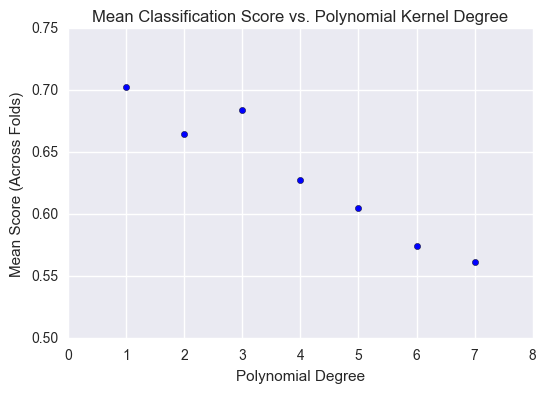

Optimal polynomial degree: 1
Optimal mean score: 0.7028101058020525
Score on training set: 0.7835642618251314
Score on validation set: 0.6891284815813118


In [62]:
degrees = np.arange(1, 8)
scores = []
for i, degree in enumerate(degrees):
    scores.append([])
    psvc = SVC(kernel = 'poly', degree = degree)
    for training, testing in kf:
        psvc.fit(X_tr_s.iloc[training], y_tr[training])
        scores[i].append(psvc.score(X_tr_s.iloc[testing], y_tr[testing]))

plt.figure()
plt.scatter(degrees, [np.mean(folds) for folds in scores])
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Score (Across Folds)')
plt.title('Mean Classification Score vs. Polynomial Kernel Degree')
plt.show()

idegree = max(enumerate(np.mean(folds) for folds in scores), key = lambda p: p[1])[0]
print('Optimal polynomial degree: {}'.format(degrees[idegree]))
print('Optimal mean score: {}'.format(np.mean(scores[idegree])))

psvc = SVC(kernel = 'poly', degree = degrees[idegree])
psvc.fit(X_tr_s, y_tr)
print('Score on training set: {}'.format(psvc.score(X_tr_s, y_tr)))
print('Score on validation set: {}'.format(psvc.score(X_val_s, y_val)))

### ========== Question 1.26 ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

One significant advantage of cross-validation is that combining the models resulting from training on multiple subsets of data is less likely to result in overfitting than only using one training set, as long as the subsets are reasonably diverse. However, the computational cost of cross-validation is very high, as the model needs to be retrained several times as opposed to once, and this increases linearly with the number of folds. Hold-out validation is easier to implement, as the data only needs to be partitioned once, and the training phase does not need to be completed multiple times. On the other hand, it's more susceptible to overfitting, and a poorly-distributed partition can worsen this and/or suggest a lower score than real-world performance. Cross-validation's multiple partitions make this far less likely, and I would trust it more in practice.

### ========== Question 1.27 ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [63]:
X_tr = train_A.drop(['imgId', 'is_person'], axis = 1)
y_tr = train_A['is_person']
X_val = valid_A.drop(['imgId', 'is_person'], axis = 1)
y_val = valid_A['is_person']

ss = StandardScaler()
ss.fit(X_tr)
X_tr_s = pd.DataFrame(data = ss.transform(X_tr), columns = X_tr.columns)
X_val_s = pd.DataFrame(data = ss.transform(X_val), columns = X_val.columns)

rfc = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 31)
rfc.fit(X_tr_s, y_tr)

print('Score on training set: {}'.format(rfc.score(X_tr_s, y_tr)))
print('Score on validation set: {}'.format(rfc.score(X_val_s, y_val)))

print('50 most important features:')
print([X_tr_s.columns[p[0]] for p in sorted(enumerate(rfc.feature_importances_),
                                            key = lambda p: p[1], reverse = True)[:50]])

Score on training set: 1.0
Score on validation set: 0.7115902964959568
50 most important features:
['is_cat', 'is_bird', 'dim21', 'dim51', 'dim360', 'dim4', 'dim76', 'dim398', 'dim283', 'dim479', 'dim263', 'dim343', 'dim423', 'dim485', 'dim254', 'dim461', 'dim222', 'dim356', 'dim74', 'dim288', 'dim214', 'dim348', 'dim330', 'dim217', 'dim483', 'dim90', 'dim274', 'dim347', 'dim17', 'dim427', 'dim35', 'dim326', 'dim73', 'dim312', 'dim48', 'dim25', 'dim315', 'dim322', 'dim329', 'dim500', 'dim134', 'dim206', 'is_aeroplane', 'dim96', 'dim353', 'dim442', 'dim77', 'dim440', 'dim171', 'dim154']


Looking at the 50 most important features in the random forest classifier, one can see that only three of the additional class indicator variables show up, though two (is_cat and is_bird) are at the very top of the list. This makes it less surprising that the performance on validation data is only slightly better than in 1.16, since while some classes do clearly aid in the classification, most have little effect. I have verified this by looking at the 50 least important features, in which I counted 14 class indicators.

Looking at the images in the dataset, I didn't see any containing both a person and a cat, bird, or airplane, but found several that involved other forms of transportation with some containing humans, and many such classes are at the bottom of the important features list. I would hypothesize that these indicators do not contribute much to the is_person classification because they appear with similar frequency both with and without humans.

I would expect that the indicators that were most important could be used in practice, since the score did improve slightly, but the rest at the bottom of the list are likely little better than noise and should be thrown out. Perhaps it would be best to first determine which indicators have a strong positive or negative correlation with the target class, and throw out the rest.

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classiffier you like (with the provison that you can explain what the classiffier/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the posterior probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated posterior probabilities for the data points in the test set into a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. You are then required to copy this file into your submission folder along with your notebook (see Mecanics section at the top of the notebook) and then submit the two files by using the `submit` command on DICE. You are only required to use the `submit` command once.

In order to achieve maximum performance, I worked through several approaches, concluding with the code below. Based on part A, I chose a support vector machine using a radial basis function kernel as my ultimate classification method, because it scored highly and generalized well.

The first optimization I made was to use a StandardScaler to scale each feature to a mean of 0 and variance of 1, as in part A. This prevents any  axis from dominating others in the SVM's boundary solution, and avoids potential floating-point math errors.

Next, I added code to search the parameter space of C and gamma in order to maximize cross-validated performance on the training data. In this case, cross-validation is more reliable than evaluating each pair on the validation data alone, as quirks in the validation data could obfuscate the optimal values of C and gamma for generalized classification. This achieved performance similar to when these values were optimized over a grid in part A. Initially, I used a recursive binary search to fixed precision along each axis of C-gamma space, but eventually settled on scikit's GridSearchCV class as its multithreaded implementation was faster and produced comparable results. It became clear that this had to be the last step of my pipeline, as any preprocessing of the training data would affect the maximal solution for these parameters.

Taking the hint's suggestion, I set about combining information from multiple models with preprocessing methods. It seemed plausible that a number of the 500 features contributed little more than noise, so I searched for a way to find the best subset. Any scheme involving partitioning features into possible subsets and re-running my pipeline on each would clearly have been prohibitively expensive. Digging into scikit's documentation, I found the SelectFromModel class, which can be used with any model that assigns importance to each feature in order to throw out those least useful in classification. I settled on a RandomForestClassifier with 500 entropy-based decision trees, as this also seemed to perform remarkably well in part A. When I used this to discard features with importance less than the cumulative mean, my score on the validation set was slightly less than 72%, but changing the threshold to the median got close to 73%, so that is what I used. Given more resources, one could use a method such as binary search to find the optimal threshold, but this simple reduction in features was enough to yield an improvement.

Finally, I attempted to capture possibly nonlinear interactions between features by using a PolynomialFeatures object to add a new feature for every pair of original ones. At first I tried to do this before selecting the most important, but this generated far too many and made it difficult to train a RandomForestClassifier in a reasonable amount of time, so I added the features after one pass of the SelectFromModel transformation. I then trained a RandomForestClassifier on the on the training data with polynomial features, and used another SelectFromModel transformation to throw out some of the thousands of features. However, even taking those with median or mean importance and above only eliminated 1/3-1/2 of all features, such that grid searches to optimize C and gamma did not complete after several hours. I also tried manually limiting the new training data to various amounts of features (100, 200, 250, 500, 1000), and even after parameter optimization, none of these sets performed as well on the validation data as before adding polynomial features. As a result, I eventually abandoned this idea.

In [2]:
train_B = pd.read_csv('datasets/train_images_partB.csv').drop('imgId', axis = 1)
valid_B = pd.read_csv('datasets/valid_images_partB.csv').drop('imgId', axis = 1)
test_B = pd.read_csv('datasets/test_images_partB.csv')

attrs = ['dim{}'.format(n) for n in xrange(1, 501)]
X_tr = train_B[attrs]
y_tr = train_B['is_person']
X_va = valid_B[attrs]
y_va = valid_B['is_person']
X_te = test_B[attrs]

ss = StandardScaler()
ss.fit(X_tr)
X_tr_s = pd.DataFrame(data = ss.transform(X_tr), columns = X_tr.columns)
X_va_s = pd.DataFrame(data = ss.transform(X_va), columns = X_va.columns)
X_te_s = pd.DataFrame(data = ss.transform(X_te), columns = X_te.columns)

In [3]:
rfc = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
rfc.fit(X_tr_s, y_tr)
sfm = SelectFromModel(rfc, threshold = 'median', prefit = True)

X_tr_sf = pd.DataFrame(data = sfm.transform(X_tr_s),
                       columns = [X_tr_s.columns[i] for i in sfm.get_support(indices = True)])
X_va_sf = X_va_s[X_tr_sf.columns]
X_te_sf = X_te_s[X_tr_sf.columns]

In [4]:
# Unused
pf = PolynomialFeatures(interaction_only = True, include_bias = False)
X_tr_sfp = pd.DataFrame(data = pf.fit_transform(X_tr_sf),
                        columns = ['dim{}'.format(i) for i in xrange(pf.n_output_features_)])
X_va_sfp = pd.DataFrame(data = pf.transform(X_va_sf), columns = X_tr_sfp.columns)
X_te_sfp = pd.DataFrame(data = pf.transform(X_te_sf), columns = X_tr_sfp.columns)

ss.fit(X_tr_sfp)
X_tr_sfps = pd.DataFrame(data = ss.transform(X_tr_sfp), columns = X_tr_sfp.columns)
X_va_sfps = pd.DataFrame(data = ss.transform(X_va_sfp), columns = X_va_sfp.columns)
X_te_sfps = pd.DataFrame(data = ss.transform(X_te_sfp), columns = X_te_sfp.columns)

In [5]:
# Unused
rfc.fit(X_tr_sfps, y_tr)
importances = sorted(enumerate(rfc.feature_importances_), key = lambda p: p[1], reverse = True)

In [15]:
# Unused
sfm = SelectFromModel(rfc, threshold = 'median', prefit = True)

X_tr_sfpsf = pd.DataFrame(data = sfm.transform(X_tr_sfps),
                          columns = [X_tr_sfps.columns[i] for i in sfm.get_support(indices = True)])
X_va_sfpsf = X_va_sfps[X_tr_sfpsf.columns]
X_te_sfpsf = X_te_sfps[X_tr_sfpsf.columns]

In [ ]:
# Unused
gscv = GridSearchCV(SVC(kernel = 'rbf'), {'C': np.logspace(-4, 4, 3), 'gamma': np.logspace(-4, 4, 3)})

gscv.fit(X_tr_sfpsf, y_tr)
print(gscv.score(X_tr_sfpsf, y_tr))
print(gscv.score(X_va_sfpsf, y_va))

In [19]:
gscv = GridSearchCV(SVC(kernel = 'rbf', probability = True), {'C': np.logspace(-4, 4, 17), 'gamma': np.logspace(-4, 4, 17)})

gscv.fit(X_tr_sf, y_tr)
print(gscv.score(X_tr_sf, y_tr))
print(gscv.score(X_va_sf, y_va))

0.913393279697
0.722371967655


In [20]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array has not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

save_predictions(gscv.predict_proba(X_te_sf))